In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
# Append the directory to your python path using sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

In [ ]:
import numpy as np
import torch.utils.data as Data
from PIL import Image
from scipy import stats
import torch
import torchvision.transforms as transforms
from math import inf
import torch
import numpy as np
from scipy.stats import truncnorm
from torch.nn import functional as F
from math import inf
from torchvision import datasets, transforms


def transform_target(label):
    label = np.array(label)
    target = torch.from_numpy(label).long()
    return target

def data_split(data, targets, split_percentage, seed=1):

    num_samples = int(targets.shape[0])
    np.random.seed(int(seed))
    train_set_index = np.random.choice(num_samples, int(num_samples*split_percentage), replace=False)
    index = np.arange(data.shape[0])
    val_set_index = np.delete(index, train_set_index)
    train_set, val_set = data[train_set_index, :], data[val_set_index, :]
    train_labels, val_labels = targets[train_set_index], targets[val_set_index]

    return train_set, val_set, train_labels, val_labels

class cifar10_dataset(Data.Dataset):
    def __init__(self, train=True, transform=None, target_transform=None, noise_rate=0.8, split_percentage=0.9, seed=1, num_classes=10, feature_size=3*32*32, norm_std=0.1):

        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        original_images = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/train_images.npy')
        original_labels = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/train_labels.npy')
        data = torch.from_numpy(original_images).float()
        targets = torch.from_numpy(original_labels)

        dataset = zip(data, targets)
        new_labels = get_instance_noisy_label(noise_rate, dataset, targets, num_classes, feature_size, norm_std, seed)


        self.train_data, self.train_labels= original_images, new_labels
        print(self.train_data.shape)


    def __getitem__(self, index):

        if self.train:
            img, label = self.train_data[index], self.train_labels[index]

        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label
    def __len__(self):

        if self.train:
            return len(self.train_data)

In [ ]:
def get_instance_noisy_label(n, dataset, labels, num_classes, feature_size, norm_std, seed):
    # n -> noise_rate
    # dataset -> mnist, cifar10 # not train_loader
    # labels -> labels (targets)
    # label_num -> class number
    # feature_size -> the size of input images (e.g. 28*28)
    # norm_std -> default 0.1
    # seed -> random_seed
    print("building dataset...")
    label_num = num_classes
    np.random.seed(int(seed))
    torch.manual_seed(int(seed))
    torch.cuda.manual_seed(int(seed))

    P = []
    flip_distribution = stats.truncnorm((0 - n) / norm_std, (1 - n) / norm_std, loc=n, scale=norm_std)
    flip_rate = flip_distribution.rvs(labels.shape[0])

    if isinstance(labels, list):
        labels = torch.FloatTensor(labels)
    labels = labels.cuda()

    W = np.random.randn(label_num, feature_size, label_num)


    W = torch.FloatTensor(W).cuda()
    for i, (x, y) in enumerate(dataset):
        # 1*m *  m*10 = 1*10
        x = x.cuda()
        A = x.view(1, -1).mm(W[y]).squeeze(0)
        A[y] = -inf
        A = flip_rate[i] * F.softmax(A, dim=0)
        A[y] += 1 - flip_rate[i]
        P.append(A)
    P = torch.stack(P, 0).cpu().numpy()
    l = [i for i in range(label_num)]
    new_label = [np.random.choice(l, p=P[i]) for i in range(labels.shape[0])]
    record = [[0 for _ in range(label_num)] for i in range(label_num)]

    for a, b in zip(labels, new_label):
        a, b = int(a), int(b)
        record[a][b] += 1


    pidx = np.random.choice(range(P.shape[0]), 1000)
    cnt = 0
    for i in range(1000):
        if labels[pidx[i]] == 0:
            a = P[pidx[i], :]
            cnt += 1
        if cnt >= 10:
            break
    return np.array(new_label)

In [ ]:
num_classes = 10
feature_size = 3 * 32 * 32
n_epoch_1, n_epoch_2, n_epoch_3 = 5, 50, 50
dim = 512
basis = 20
iteration_nmf = 10
train_dataset = cifar10_dataset(True,
                                    transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
                                    ]),
                                    target_transform=transform_target)

building dataset...
(50000, 3072)


[[2.078e-01 0.000e+00 2.000e-04 3.600e-03 2.000e-04 7.200e-03 8.000e-04
  4.400e-03 5.180e-02 7.240e-01]
 [1.940e-02 2.114e-01 3.326e-01 8.800e-03 2.000e-04 0.000e+00 1.866e-01
  2.400e-03 9.980e-02 1.388e-01]
 [3.380e-01 4.640e-02 2.134e-01 2.340e-02 0.000e+00 9.600e-03 0.000e+00
  3.682e-01 0.000e+00 1.000e-03]
 [8.920e-02 4.500e-02 2.106e-01 1.974e-01 9.920e-02 2.600e-03 5.400e-03
  1.480e-02 7.180e-02 2.640e-01]
 [8.000e-04 0.000e+00 8.200e-03 0.000e+00 2.050e-01 2.000e-04 1.200e-02
  7.738e-01 0.000e+00 0.000e+00]
 [4.600e-03 3.200e-03 1.200e-03 5.254e-01 2.660e-02 2.028e-01 1.820e-01
  8.400e-03 2.000e-03 4.380e-02]
 [2.000e-04 3.820e-02 5.080e-02 1.612e-01 0.000e+00 3.600e-03 2.046e-01
  6.000e-04 8.000e-04 5.400e-01]
 [0.000e+00 6.000e-04 2.000e-04 5.296e-01 1.600e-03 0.000e+00 4.000e-04
  1.964e-01 0.000e+00 2.712e-01]
 [7.234e-01 3.280e-02 0.000e+00 2.860e-02 1.600e-03 0.000e+00 0.000e+00
  8.200e-03 2.054e-01 0.000e+00]
 [0.000e+00 4.400e-03 2.000e-04 2.000e-04 1.800e-03 0.0

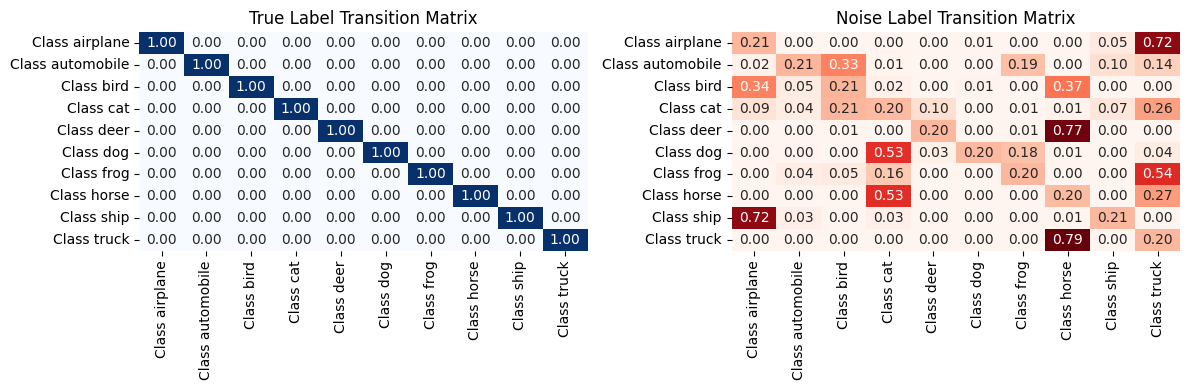

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import random

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_transition_matrix(true_labels, noise_labels, num_classes=10):
    # Compute confusion matrix for true labels
    true_conf_matrix = confusion_matrix(true_labels, true_labels)

    # Compute confusion matrix for noise labels
    noise_conf_matrix = confusion_matrix(true_labels, noise_labels)

    # Normalize confusion matrices to get transition probabilities
    true_transitions = true_conf_matrix / true_conf_matrix.sum(axis=1, keepdims=True)
    noise_transitions = noise_conf_matrix / noise_conf_matrix.sum(axis=1, keepdims=True)
    print(noise_transitions)
    # Plot true label transition matrix
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(true_transitions, annot=True, cmap="Blues", fmt=".2f", cbar=False,
                xticklabels=[f'Class {classes[i]}' for i in range(num_classes)],
                yticklabels=[f'Class {classes[i]}' for i in range(num_classes)])
    plt.title('True Label Transition Matrix')

    # Plot noise label transition matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(noise_transitions, annot=True, cmap="Reds", fmt=".2f", cbar=False,
                xticklabels=[f'Class {classes[i]}' for i in range(num_classes)],
                yticklabels=[f'Class {classes[i]}' for i in range(num_classes)])
    plt.title('Noise Label Transition Matrix')

    plt.tight_layout()
    plt.show()
original_labels = np.load('/content/drive/MyDrive/Colab Notebooks/data/cifar10/train_labels.npy')
# Example usage
plot_transition_matrix(original_labels,train_dataset.train_labels, num_classes=10)



Files already downloaded and verified


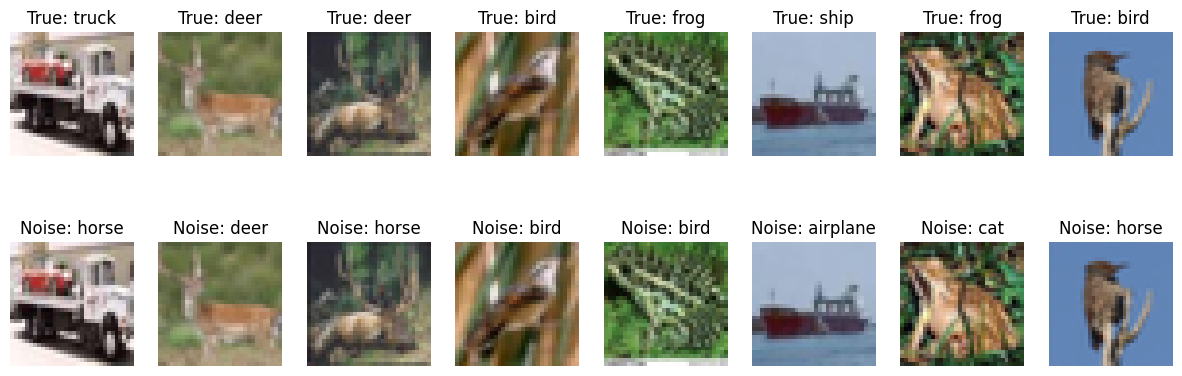

In [ ]:
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch

# Set seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# CIFAR-10 class names
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Function to plot images with true labels and noise labels
def plot_images(dataset, true_labels, noise_labels, class_names, num_images=8):
    indices = random.sample(range(len(dataset)), num_images)

    fig, axs = plt.subplots(2, num_images, figsize=(15, 5))

    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for plotting
        axs[0, i].imshow(img)
        axs[0, i].axis('off')
        axs[0, i].set_title(f'True: {class_names[true_labels[idx]]}')

        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        axs[1, i].set_title(f'Noise: {class_names[noise_labels[idx]]}')

    plt.show()

# Example usage
plot_images(cifar10_dataset, original_labels, train_dataset.train_labels, cifar_classes)
